# Explore filtering metrics using a test set

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from definitions import ROOT_DIR
import matplotlib.pyplot as plt
import seaborn as sns
from metaspace.sm_annotation_utils import SMInstance
from getpass import getpass
import random

In [3]:
def clip(img, bottom=0, top=99):
    """Remove bottom and top percentiles of image pixels"""
    lo = np.min(img)
    lo_thresh = np.max(img) / 256
    hi = np.percentile(img[img >= lo_thresh], top)
    img_clipped = np.clip(img, lo, hi)
    return img_clipped

def rescale(data, bottom=0, top=255):
    """Rescale data to lie between [min, max] values"""
    compressed = (data - np.min(data)) / np.max(data - np.min(data))
    rescaled = compressed * (top - bottom) + bottom
    return rescaled

def show_images(images, cols = 1, titles = None): # This function is not my code 
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.viridis()
        plt.imshow(rescale(clip(image)))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

How to mark wells as occupied / not occupied? Consider the following cases.

A) Crisp spot
- occupancy_ratio is high
- on_off_ratio also high, easy case

B) Empty image or image with just a few specks
- is_empty = True (in the code above this can be assigned to images with less non-zero pixels than N)
- occupancy_ratio is 0 in all wells
- on_off_ratio is 0

C) Coffee-ring spot
- occupancy_ratio is medium
- on_off_ratio is medium

D) Bright spot with faint background everywhere
- occupancy_ratio is around 1
- on_off_ratio is high

E) Delocalised spot
- occupancy_ratio is medium-high
- on_off_ratio is medium-high

F) Multiple spots
Wells are judjed on individual basis, so shouldn't be an issue

G) Bright background, suppressed spots
- occupancy_ratio is around 1
- on_off_ratio is below 1

H) Uniform background ion
- occupancy ratio is around 1
- on_off_ratio is around 1

<img src="testing_generate_pixel_stats/cases.png" width="600" style="float: left;">
<img src="testing_generate_pixel_stats/ratio_plot.png" width="300">

- Provide inputs

In [4]:
# Paths
p_root_dir = Path(ROOT_DIR)
p_test = p_root_dir  / "testing_generate_pixel_stats"
p_testset = p_test / "Quality_Labels.csv"
# For every dataset you should have this file: p_test / f"{dataset_id}_bigreport_extended.csv" 

# METASPACE
datasets = ['2021-02-17_18h14m40s', 
            '2021-04-24_23h01m24s',
            '2021-04-24_22h19m30s', 
            '2021-04-24_23h01m50s']
database = ('Spotting_project_compounds-v9', 'feb2021')
fdr = 0.5

- Log in to METASPACE

In [7]:
sm = SMInstance()
if not sm.logged_in():
    print('Enter your API key from https://metaspace2020.eu/user/me')
    sm.login(api_key=getpass())
else:
    print('Already logged in')

Enter your API key from https://metaspace2020.eu/user/me
········


- Load and conbine results of multiple datasets

In [8]:
appended_data = []
for dataset_id in datasets:
    p_data = p_test / f"{dataset_id}_bigreport_extended.csv"
    data = pd.read_csv(p_data)
    data.neutral_loss.fillna('', inplace=True)
    appended_data.append(data)

stats_all = pd.concat(appended_data)

# test
# stats_all.head()

- Load test set spreadseet and map well statistics to it

In [9]:
test_set = pd.read_csv(p_testset)
test_set.neutral_loss.fillna('', inplace=True)
test_set.image_quality = test_set.image_quality.astype(str)

test_set2 = pd.merge(test_set, stats_all, on = ['formula', 'adduct', 'neutral_loss', 'dataset_id'], how='inner')
test_set2.set_index(['formula', 'adduct', 'neutral_loss', 'dataset_id'], inplace=True)
test_set2.sort_index(inplace=True)

# test
# test_set.head()
# test_set2.head()

- Make plots using seaborn

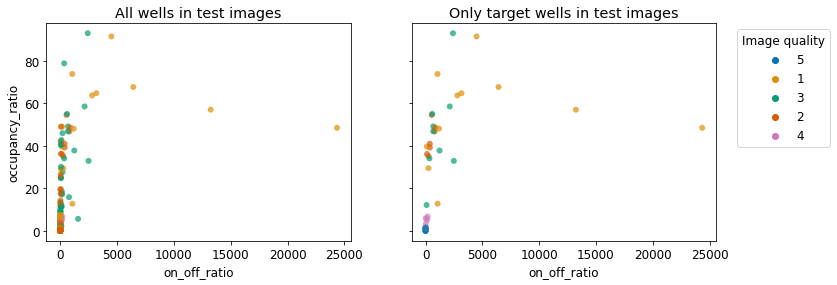

In [109]:
df = test_set2

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.set_palette(sns.color_palette("colorblind"))

# Left
sns.scatterplot(ax = axes[0], data = df, 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = 'image_quality', 
                alpha = 0.7, linewidth = 0, legend = False)
axes[0].set_title("All wells in test images")

# Centre
sns.scatterplot(ax=axes[1], data=df[df.is_target], 
                x = 'on_off_ratio', y = 'occupancy_ratio', 
                hue = 'image_quality', 
                alpha = 0.7, linewidth = 0)
axes[1].set_title("Only target wells in test images")
axes[1].legend(bbox_to_anchor= (1.05, 1), title="Image quality")

plt.show()

In [120]:
# fig = sns.scatterplot(data=df[df.is_target], 
#                 x = 'on_off_ratio', y = 'occupancy_ratio', 
#                 hue = 'image_quality', 
#                 alpha = 0.7, linewidth = 0)
# fig.set_title("ZOOM: Only target wells in test images")

# fig.axvline(on_off_thres, c='k', lw = 0.5)
# fig.axhline(occ_thres, c ='k', lw = 0.5)
# fig.set(xlim =(-50, 600), ylim = (-1, 40))

# fig.legend(bbox_to_anchor= (1.4, 1), title="Image quality")
# plt.show()

- Select reasonable thresholds
- Visualise 20 random images that pass the thresholds

In [102]:
on_off_thres = 300
occ_thres = 15

good_images = test_set2.loc[(test_set2.on_off_ratio > on_off_thres) & (test_set2.occupancy_ratio > occ_thres) & (test_set2.well != 0)]
good_images = good_images.index.unique()

bad_images = set(test_set2.index.unique()) - set(good_images)

print(f"{len(good_images)} images pass thresholds, {len(bad_images)} fail")

20 images pass thresholds, 20 fail


In [ ]:
#TODO: Calculate misclassifications

<ipython-input-3-6f0827121204>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


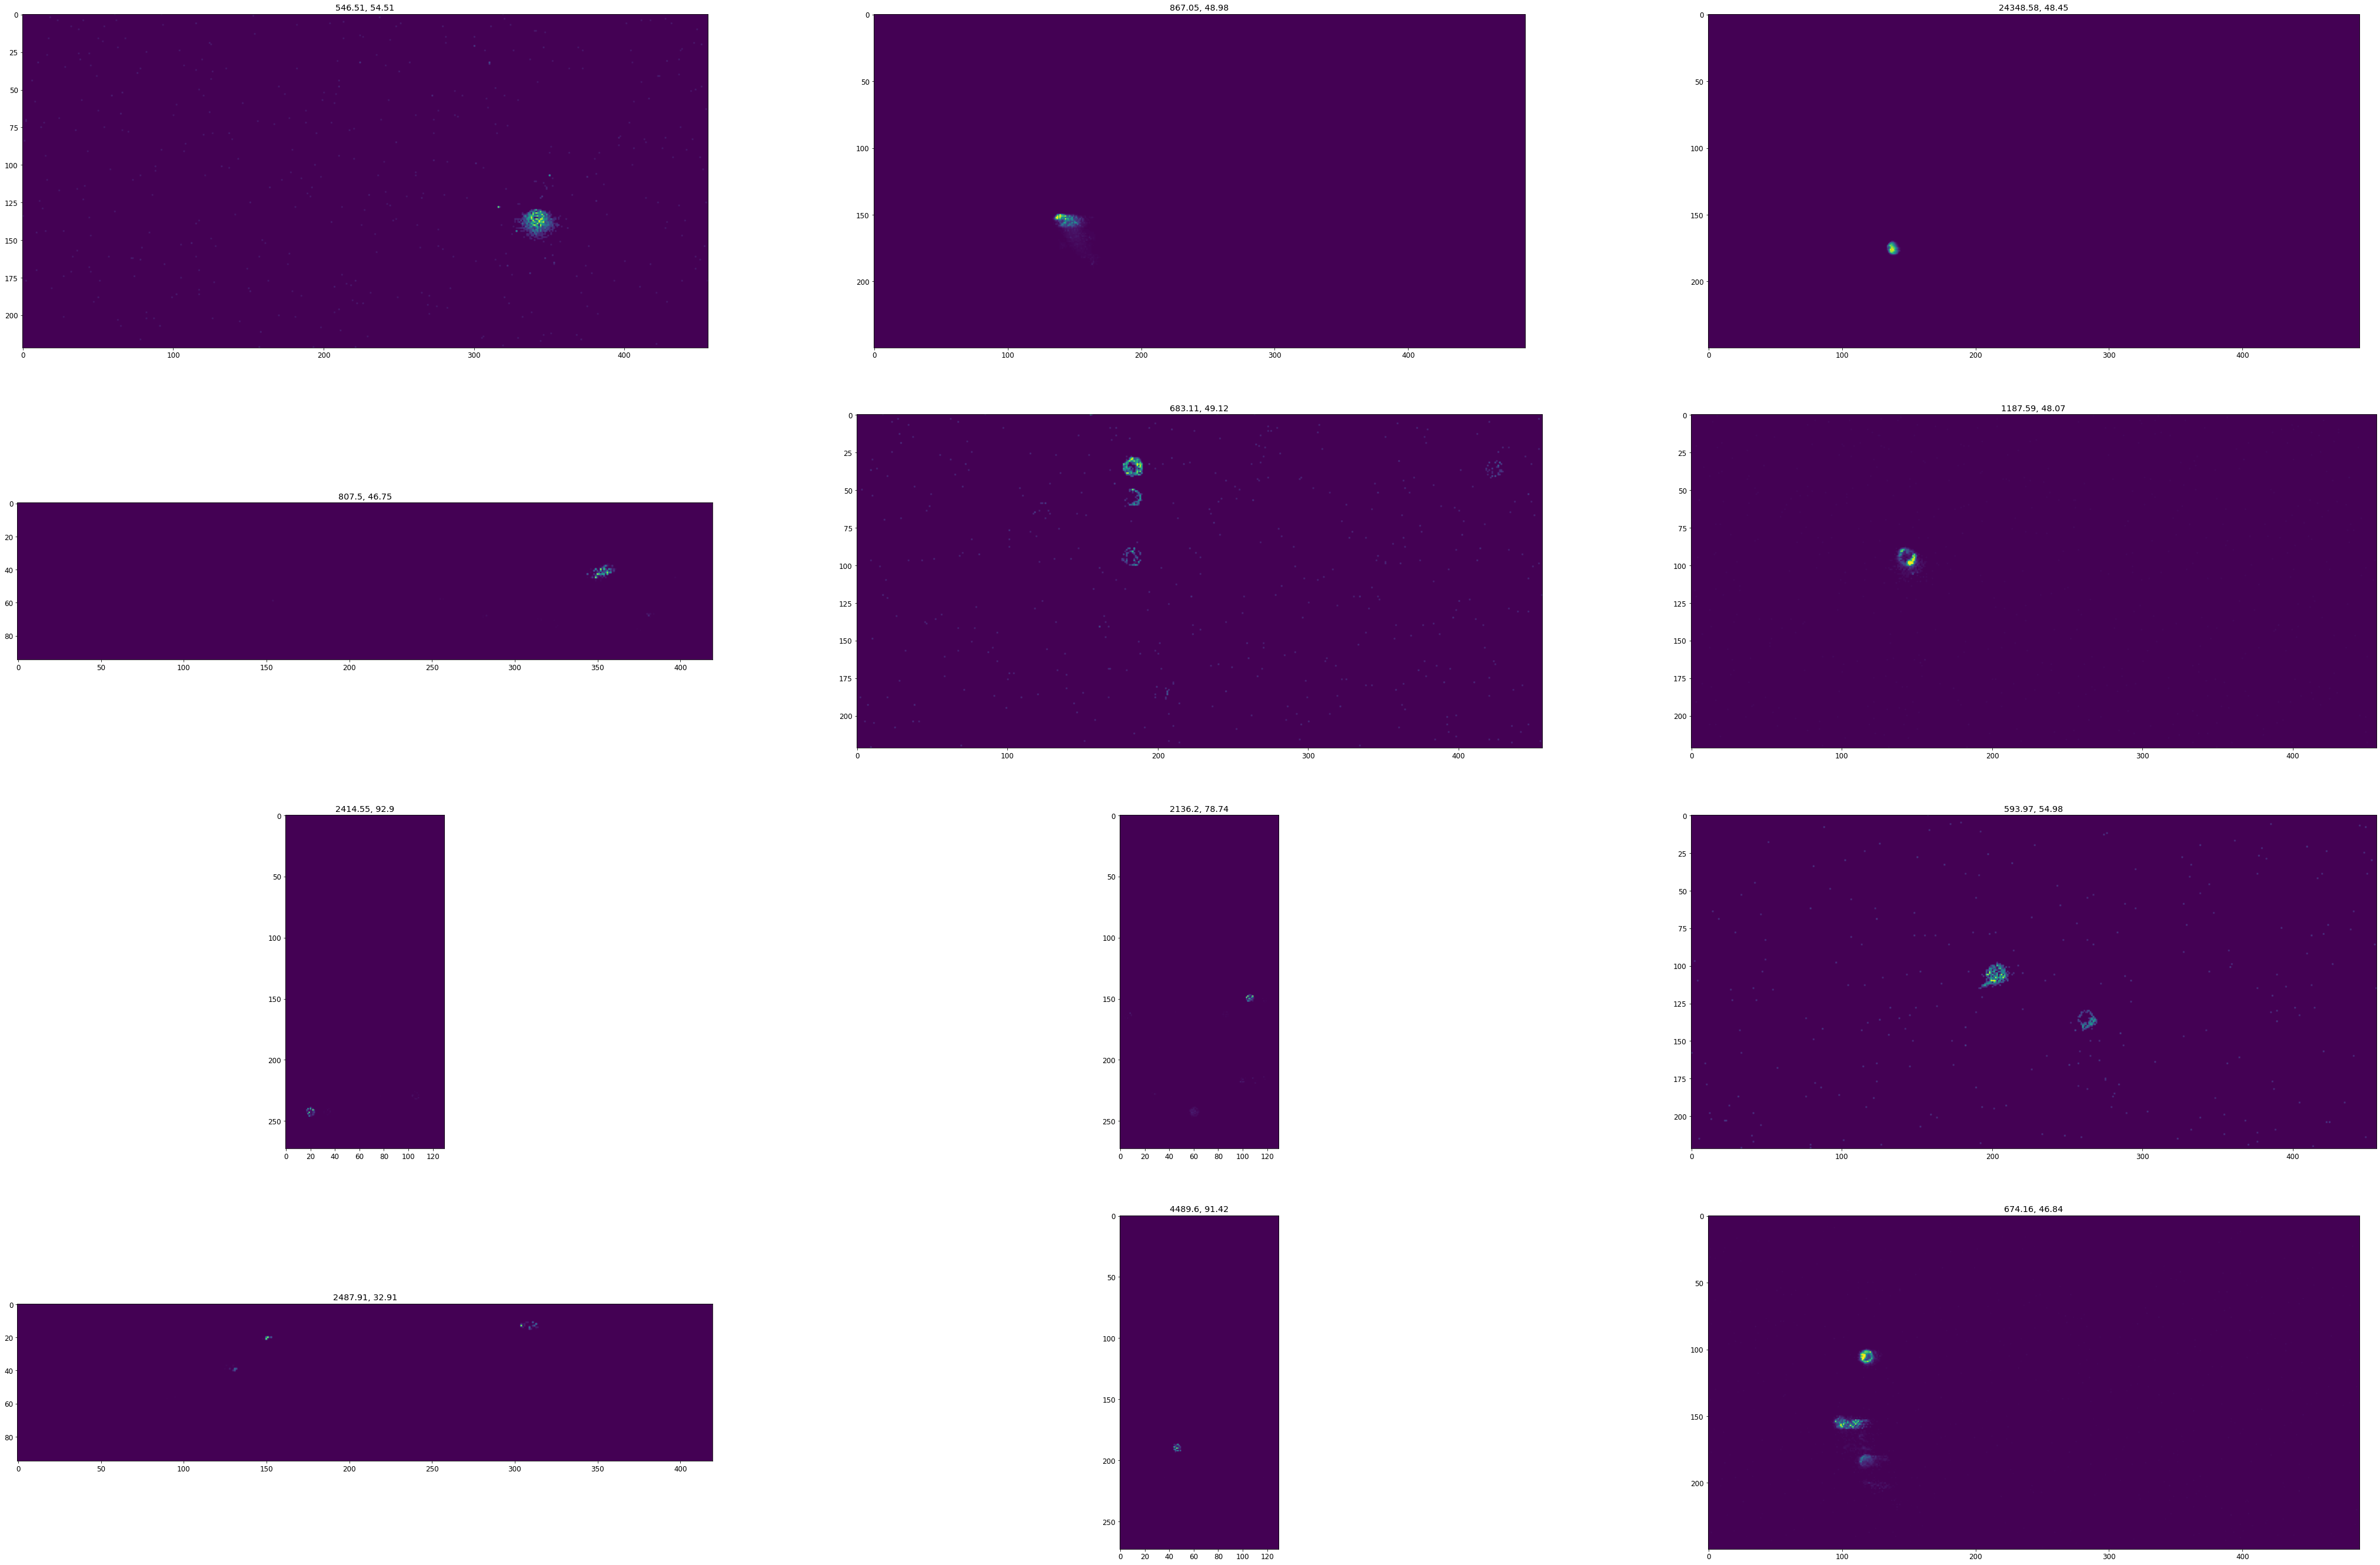

In [103]:
random_subset = random.sample(list(good_images), 12)

images = []
titles = []

for f, a, n, ds_id in random_subset:
    
    ds = sm.dataset(id = ds_id)
    image = ds.isotope_images(f, a, n)[0]
    
    max_on_off_ratio = test_set2.loc[(f, a, n, ds_id), 'on_off_ratio'].max().round(2) # for any well in this image
    max_occ_ratio = test_set2.loc[(f, a, n, ds_id), 'occupancy_ratio'].max().round(2)
    title = f"{max_on_off_ratio}, {max_occ_ratio}"
    
    images.append(image)
    titles.append(title)

plt.rcParams.update({'font.size': 40})
show_images(images=images, cols=4, titles=titles)
plt.rcParams.update({'font.size': 12}) 

<ipython-input-3-6f0827121204>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


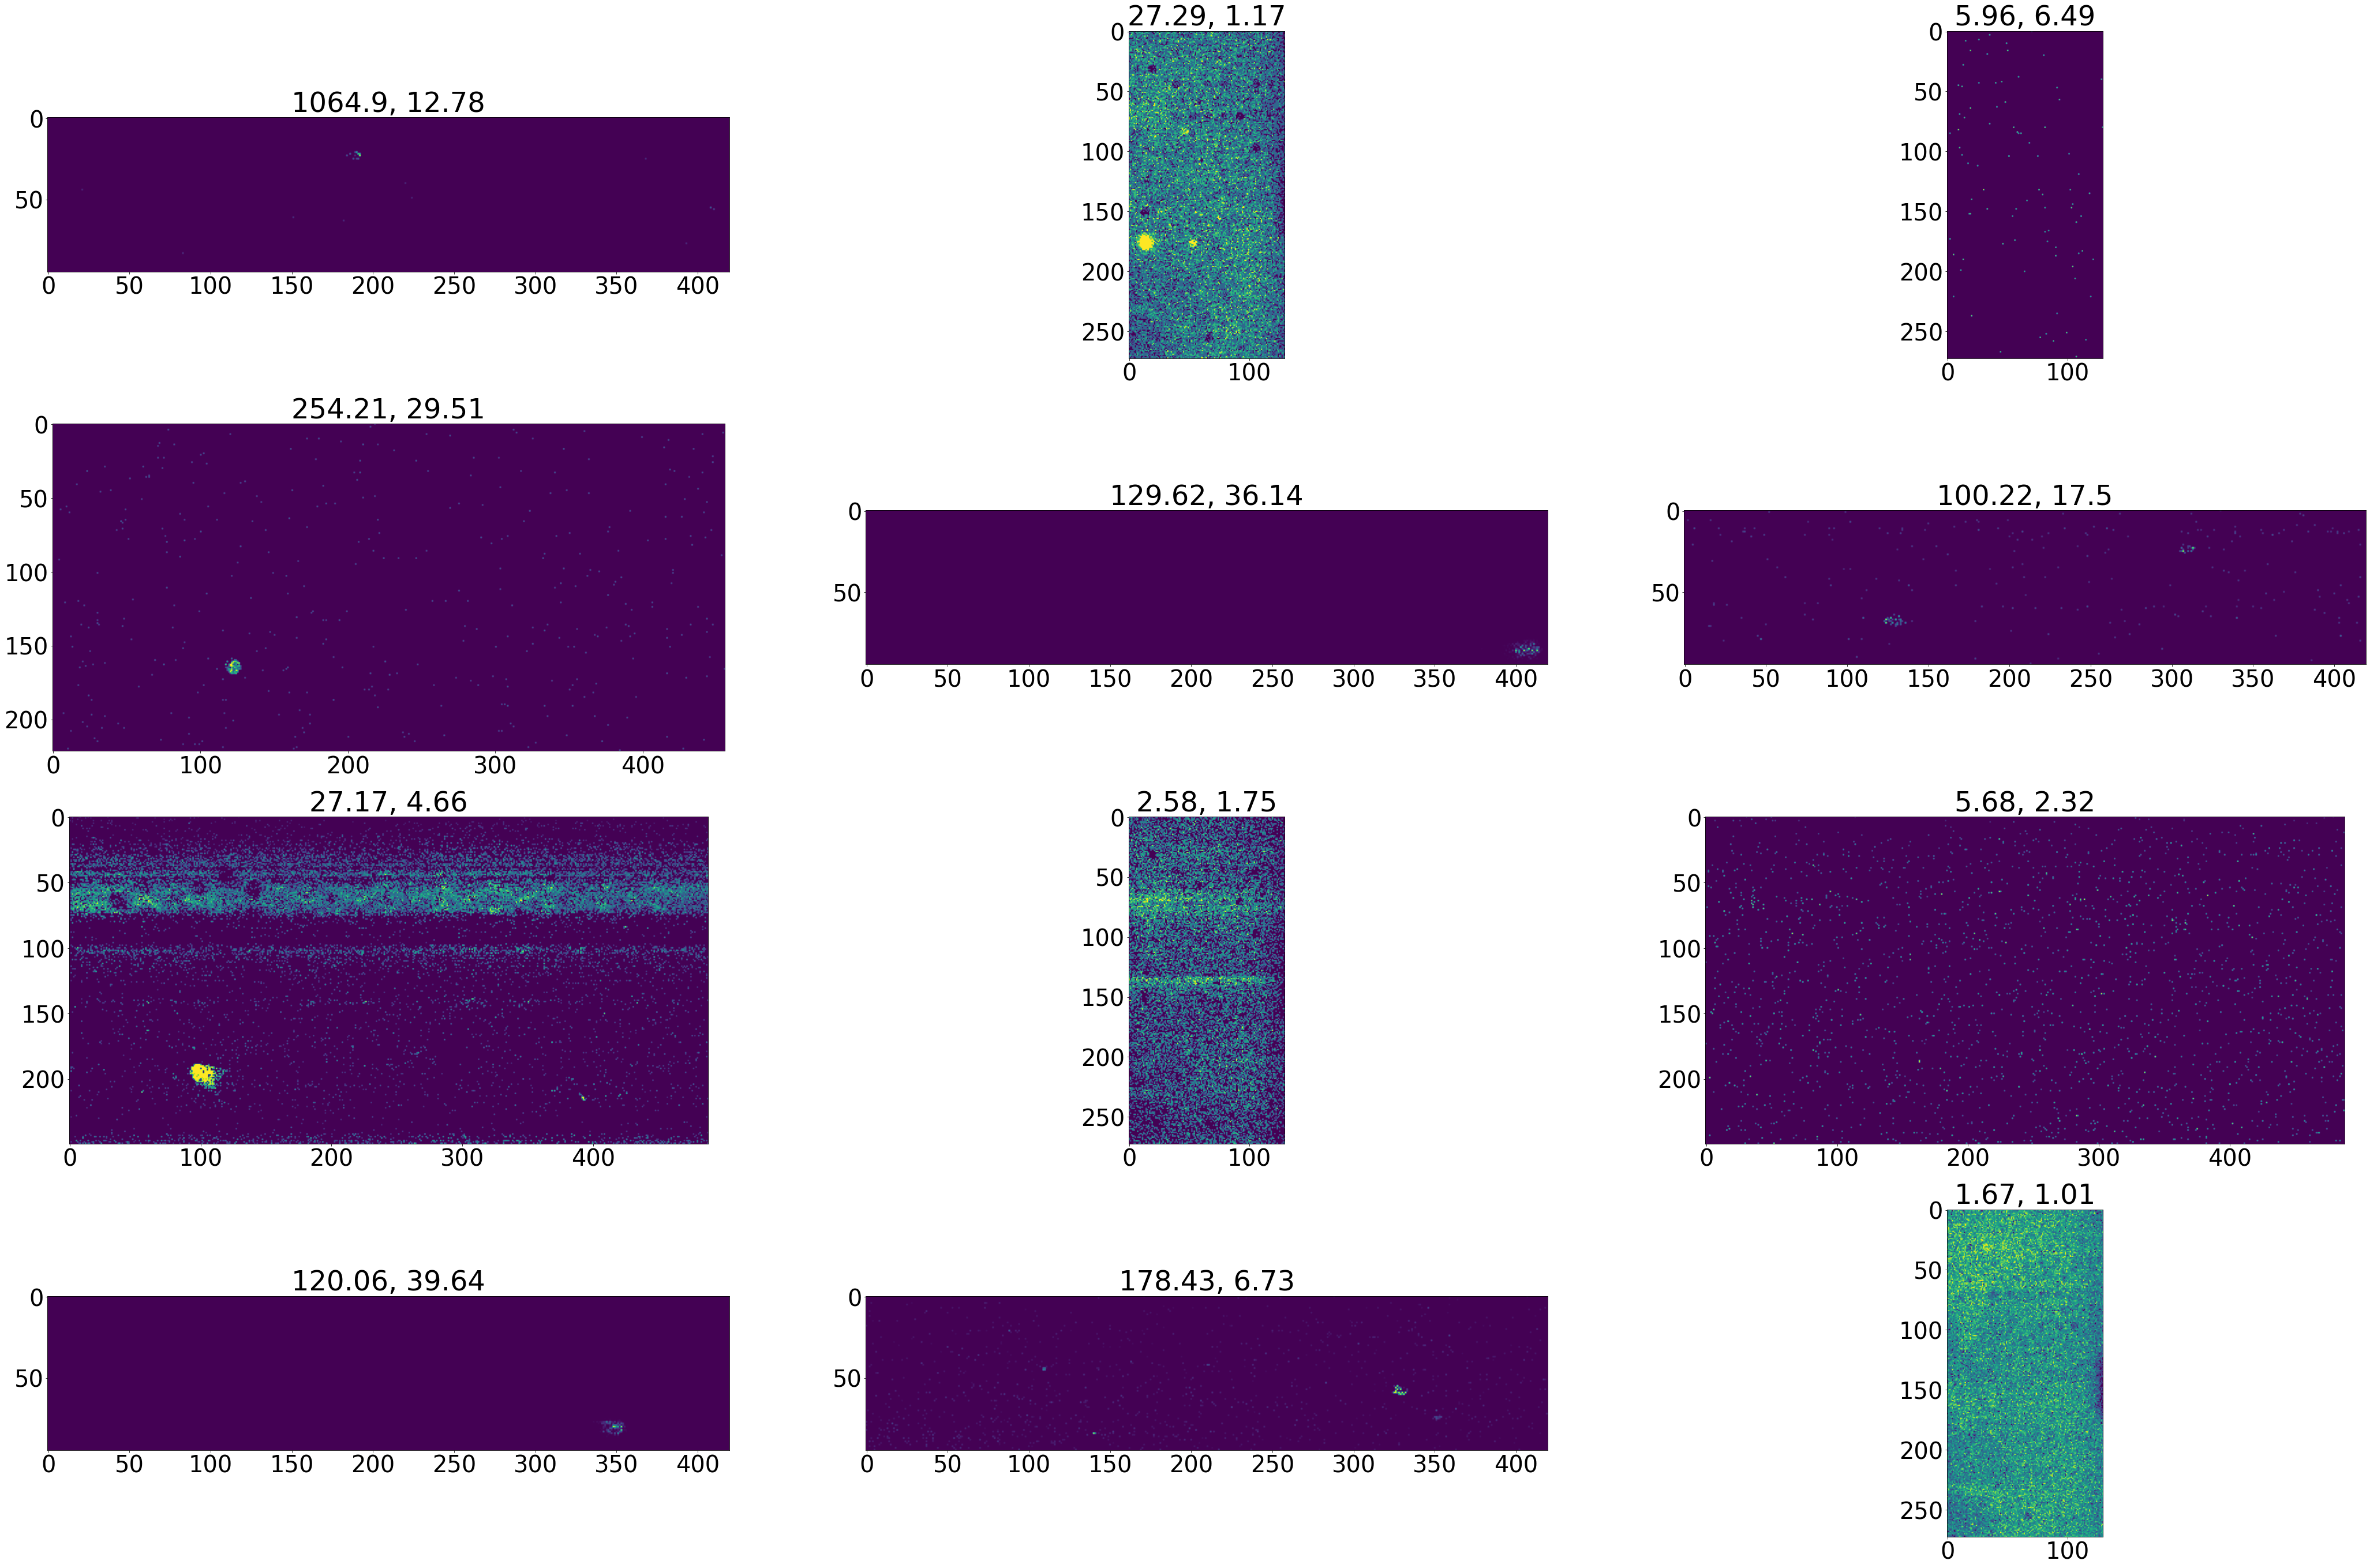

In [105]:
random_subset = random.sample(list(bad_images), 12)

images = []
titles = []

for f, a, n, ds_id in random_subset:
    
    ds = sm.dataset(id = ds_id)
    image = ds.isotope_images(f, a, n)[0]
    
    max_on_off_ratio = test_set2.loc[(f, a, n, ds_id), 'on_off_ratio'].max().round(2) # for any well in this image
    max_occ_ratio = test_set2.loc[(f, a, n, ds_id), 'occupancy_ratio'].max().round(2)
    title = f"{max_on_off_ratio}, {max_occ_ratio}"
    
    images.append(image)
    titles.append(title)

plt.rcParams.update({'font.size': 40})
show_images(images=images, cols=4, titles=titles)
plt.rcParams.update({'font.size': 12}) 